## Dataset preprocessing

Convert the bounding box file into yolo format

In [4]:
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 15.4 MB/s eta 0:00:00a 0:00:01


In [5]:
# import necessary dependencies
import json
import yaml
import shutil
import random
import pandas as pd
from pathlib import Path
from PIL import Image
from collections import Counter
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
! pip install tree

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.3 MB/s eta 0:00:00
  Created wheel for tree: filename=Tree-0.2.4-py3-none-any.whl size=7859 sha256=994596ba346ff502e61fe8bc98f8e371235bd2bd4e5c933f8fa7efc913f69307
  Stored in directory: /root/.cache/pip/wheels/06/1e/8c/73b3a97f37991dc90603631567511071513ee3c6d819393232
Successfully built tree


In [7]:
# load the json file
image_data = "/kaggle/input/polyps/Kvasir-SEG/kavsir_bboxes.json"

with open(image_data, "rb") as f_out:
    file = json.load(f_out)

In [8]:
# A quick look at the json file
# print(json.dumps(file, indent=4))

In [19]:
class_dict = {
    "polyp": 0
}


def convert_to_yolo_format(image_data, dest, img):
    for image_id, data in image_data.items():
        
        if img.stem == image_id:
            image_width = data["width"]
            image_height = data["height"]
            
            # Create a file path for the annotation the path would be defined when split the dataset
            annotation_path = dest
            
            # Prepare list to store YOLO annotations
            annotations = []
            
            # Iterate over all bounding boxes
            for bbox in data["bbox"]:
                label = bbox["label"]
                xmin = bbox["xmin"]
                ymin = bbox["ymin"]
                xmax = bbox["xmax"]
                ymax = bbox["ymax"]
                
                # Calculate YOLO format values
                x_center = ((xmin + xmax) / 2 )/ image_width
                y_center = ((ymin + ymax) / 2) / image_height
                width = (xmax - xmin) / image_width
                height = (ymax - ymin) / image_height
                
                # Get the class ID for the label
                class_id = class_dict.get(label, -1)  # -1 if label is not found
                
                # Append the YOLO annotation to the list
                annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
            
        
            with open(annotation_path, "w") as f:
                f.write("\n".join(annotations))
            
            return


For training, YOLO expects a directory structure in this format:
```
yolo_data
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val
```

so let use move the create this directory and also split the dataset into training and validation dataset

In [20]:
base_path = Path("yolo_data")

shutil.rmtree(base_path, ignore_errors=True)

image_train = base_path / "images"/"train"
image_train.mkdir(parents=True, exist_ok=True)

image_val = base_path /"images"/ "val"
image_val.mkdir(parents=True, exist_ok=True)

(base_path/ "labels"/ "train").mkdir(parents=True, exist_ok=True)
(base_path/ "labels"/"val").mkdir(parents=True, exist_ok=True)

!tree $base_path

/bin/bash: line 1: tree: command not found


Before spliting into training and validation set lets make sure that all the images have the same suffix

In [21]:
image_path = Path("/kaggle/input/polyps-dataset/Kvasir-SEG", "images")

suffix_count = Counter(f.suffix for f in image_path.glob("*"))

suffix_count

Counter({'.jpg': 1000})

In [22]:
train_frac = 0.8
images = list(image_path.glob("*"))

for img in images:
    split = "train" if random.random() < train_frac else "val"
    
    image_id = img.stem
    dest = base_path / "labels" / split / f"{img.stem}.txt"
    convert_to_yolo_format(file, dest, img)
    

    image_dest = base_path / "images" / split / f"{img.stem}.jpg"
    shutil.copy(img, image_dest)

In [23]:
# check the fraction of the dataset in each split
train_count = len(list((base_path/ "images"/"train").glob("*")))
val_count = len(list((base_path/ "images"/"val").glob("*")))
total_count = train_count + val_count

print(f"Training fraction:   {train_count/total_count:0.3f}")
print(f"Validation fraction: {val_count/total_count:0.3f}")

Training fraction:   0.810
Validation fraction: 0.190


### Create a yaml file for the data description

In [24]:

metadata = {
    "path": str(base_path.absolute()),
    "train": "images/train",
    "val": "images/val",
    "classes": "polyp",
    "nc": 1
}

print(metadata)

{'path': '/kaggle/working/yolo_data', 'train': 'images/train', 'val': 'images/val', 'classes': 'polyp', 'nc': 1}


In [25]:
yolo_config = "data.yaml"

yaml.safe_dump(metadata, open(yolo_config, 'w'))

In [26]:
!cat data.yaml

classes: polyp
nc: 1
path: /kaggle/working/yolo_data
train: images/train
val: images/val


In [27]:
model = YOLO("yolo11l.pt")

In [28]:
result = model.train(
    data= yolo_config,
    epochs=20,
    patience=5,
    batch=8
)

Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=data.yaml, epochs=20, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

train: Scanning /kaggle/working/yolo_data/labels/train... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 1059.38it/s]

train: New cache created: /kaggle/working/yolo_data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_data/labels/val... 190 images, 0 backgrounds, 0 corrupt: 100%|██████████| 190/190 [00:00<00:00, 1248.78it/s]

val: New cache created: /kaggle/working/yolo_data/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.12G      1.388      2.107      1.785          4        640: 100%|██████████| 102/102 [00:40<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

                   all        190        202    0.00432     0.0396     0.0016   0.000432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.95G      1.695      2.104      2.023          3        640: 100%|██████████| 102/102 [00:41<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

                   all        190        202    0.00432     0.0396     0.0016   0.000432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.04G      1.621      2.125      1.964          3        640: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        190        202       0.02      0.515     0.0176    0.00848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.09G      1.524      1.974      1.905          4        640: 100%|██████████| 102/102 [00:41<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        190        202      0.372      0.485       0.38      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.08G      1.482      1.963      1.857          4        640: 100%|██████████| 102/102 [00:41<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        190        202      0.523      0.381      0.411      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.05G      1.429      1.805      1.785          5        640: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

                   all        190        202      0.581       0.53      0.561      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.01G      1.309       1.72      1.728          5        640: 100%|██████████| 102/102 [00:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        190        202      0.586      0.619      0.617      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.09G      1.309      1.668      1.714          6        640: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        190        202      0.704      0.625      0.701      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.08G      1.247      1.577      1.662          3        640: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        190        202      0.729      0.651      0.713      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.09G      1.206      1.501       1.64          5        640: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        190        202      0.628      0.543      0.585      0.371


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.04G      1.118      1.422      1.629          2        640: 100%|██████████| 102/102 [00:41<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

                   all        190        202      0.634       0.73      0.736      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.09G      1.045      1.289      1.556          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]

                   all        190        202      0.641      0.707      0.748      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.09G      1.032      1.221      1.535          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        190        202      0.795      0.708      0.797      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.06G     0.9994      1.183      1.509          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        190        202      0.779      0.715       0.78      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.04G     0.9847      1.143      1.514          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        190        202      0.754      0.775      0.813      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.09G     0.9403       1.08      1.448          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        190        202       0.84      0.755      0.853      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.08G     0.9134     0.9835      1.439          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        190        202      0.834      0.822      0.883      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.08G     0.8582     0.9534      1.375          2        640: 100%|██████████| 102/102 [00:41<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        190        202      0.834       0.82      0.881      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.04G     0.8305     0.9432      1.356          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        190        202      0.834      0.799      0.878      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.09G     0.8124     0.9008      1.349          2        640: 100%|██████████| 102/102 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        190        202      0.877      0.817       0.89      0.689



20 epochs completed in 0.259 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 51.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


                   all        190        202      0.876      0.817       0.89       0.69


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 14.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


In [29]:
save_dir = result.save_dir

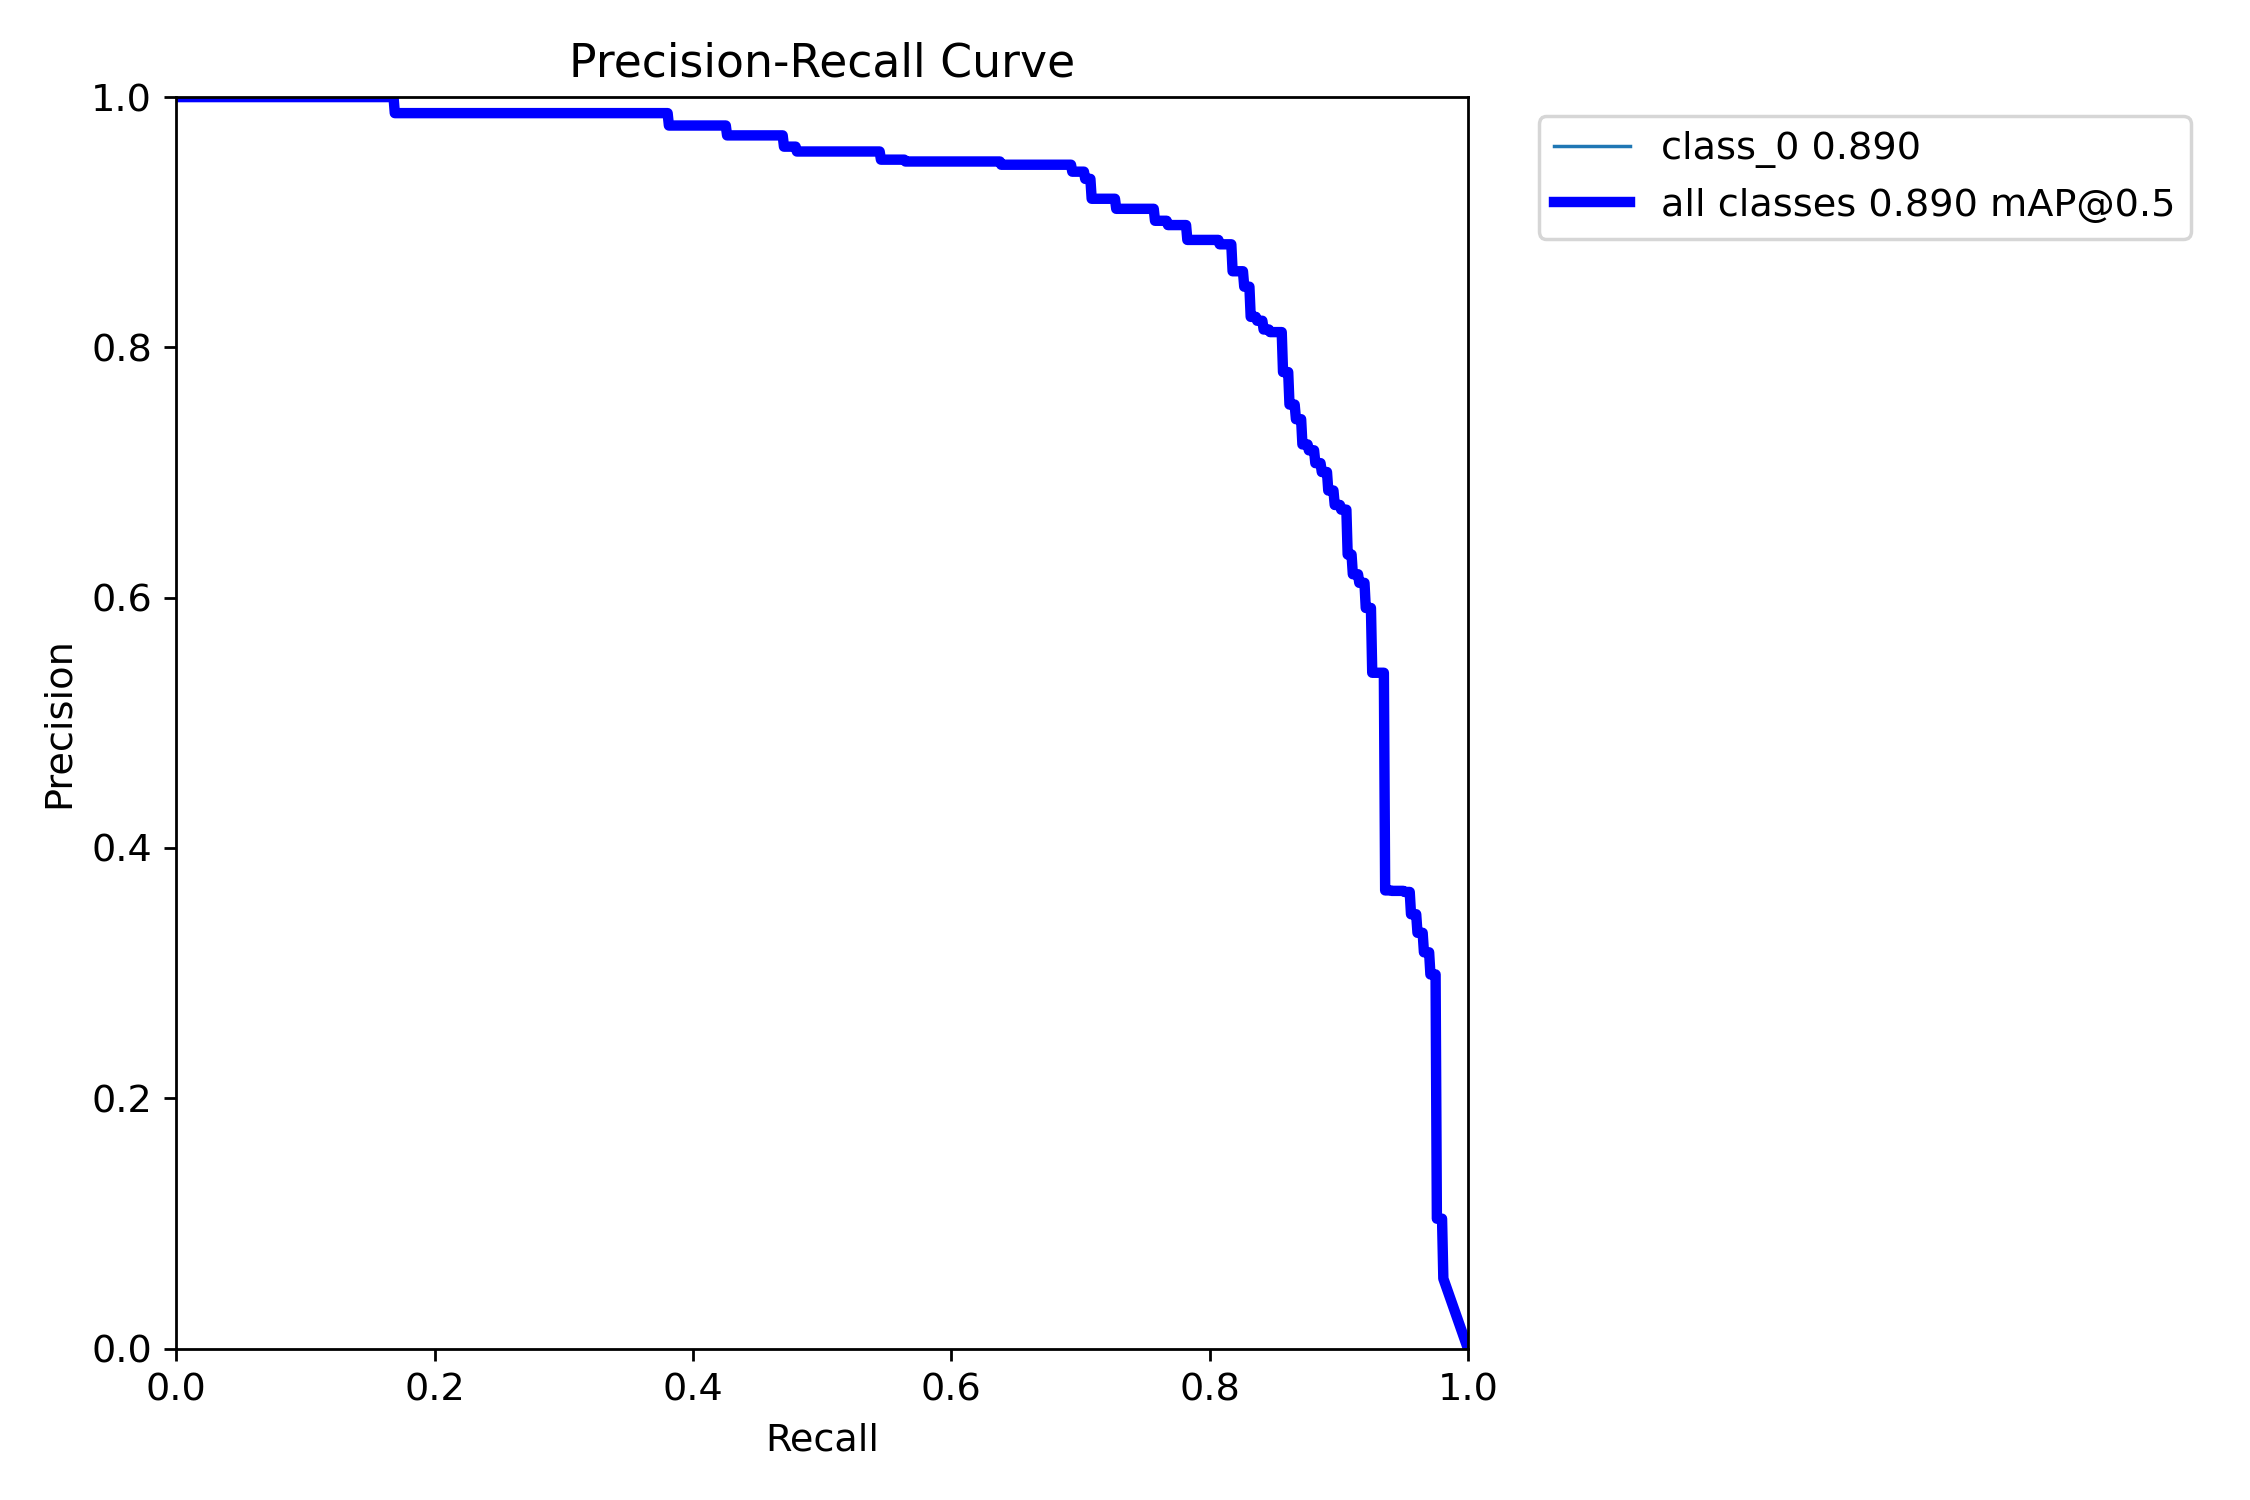

In [30]:
Image.open(save_dir/ "PR_curve.png")

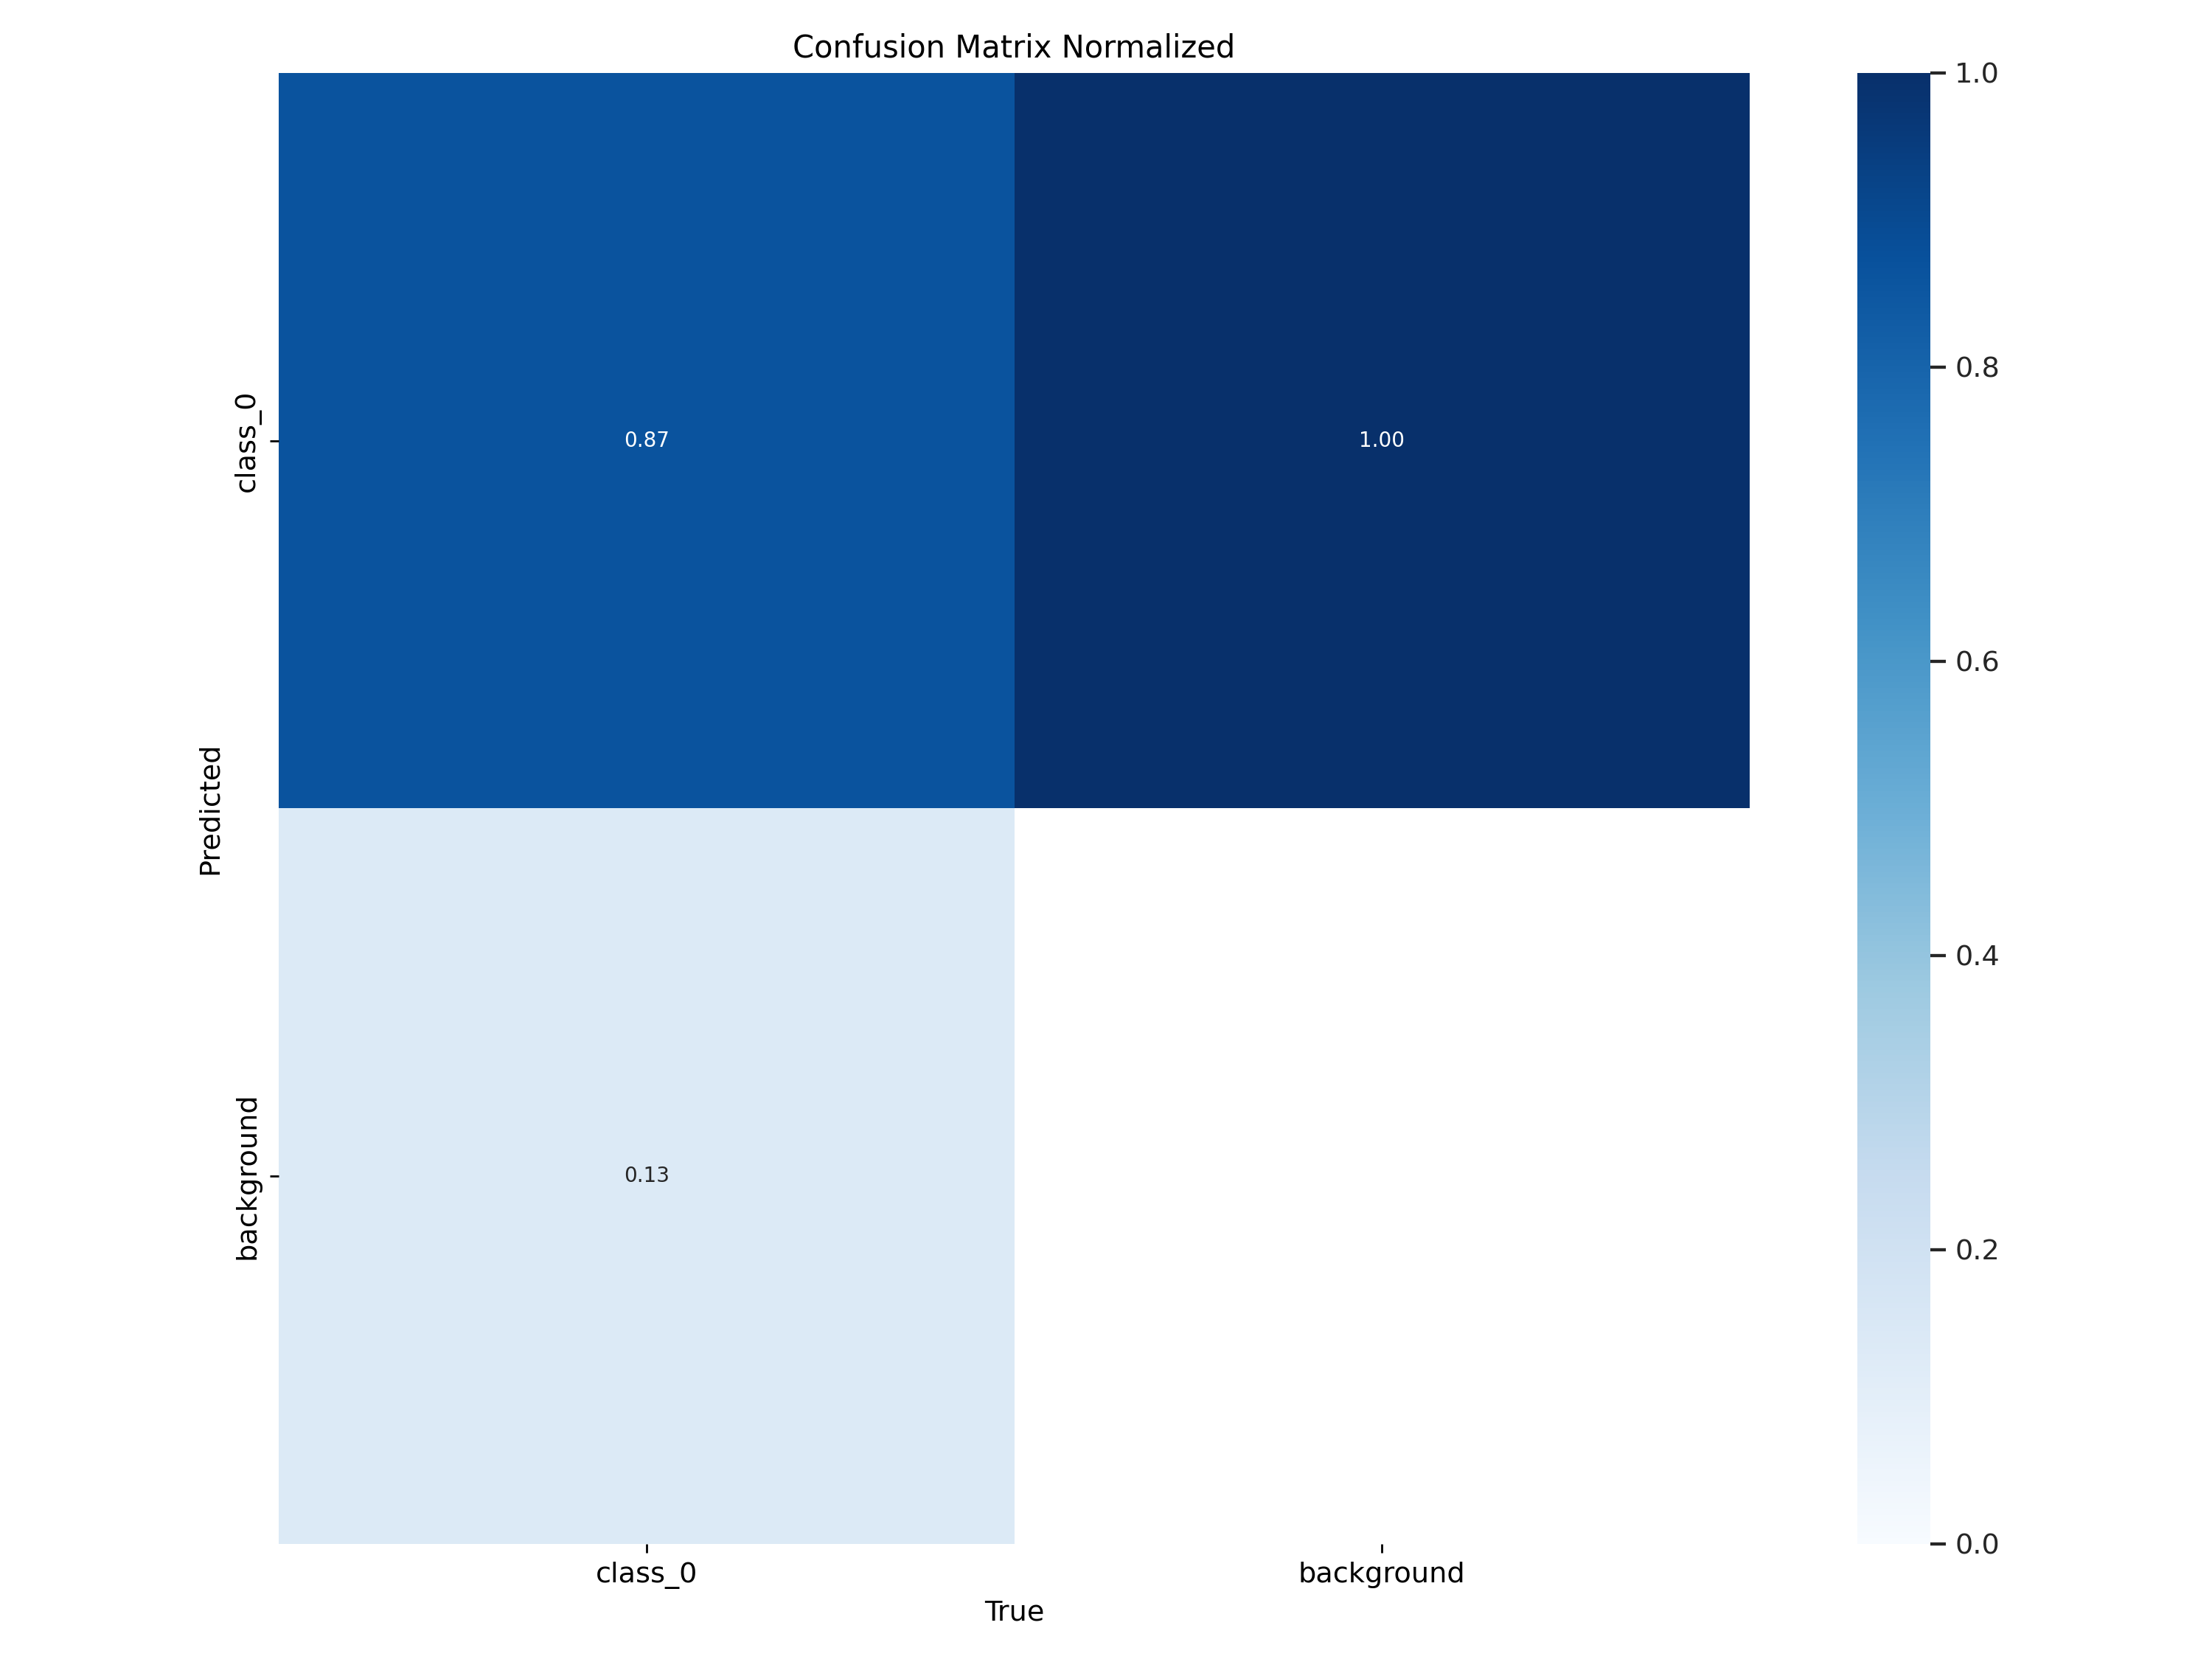

In [31]:
Image.open(save_dir/"confusion_matrix_normalized.png")

In [32]:
df = pd.read_csv(save_dir / "results.csv", skipinitialspace=True).set_index(
    "epoch"
)
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
epoch,,,,,,,,,,,,,,
1,53.6772,1.38759,2.10691,1.78474,0.00432,0.03960,0.00160,0.00043,3.59265,26.19640,6.56286,0.000660,0.000660,0.000660
2,99.6987,1.69488,2.10438,2.02338,0.00432,0.03960,0.00160,0.00043,NaN,NaN,NaN,0.001261,0.001261,0.001261
3,146.4380,1.62090,2.12493,1.96414,0.02002,0.51485,0.01762,0.00848,1.56275,76.57230,2.29902,0.001796,0.001796,0.001796
4,192.7200,1.52450,1.97432,1.90495,0.37222,0.48515,0.37977,0.18114,1.48352,5.80332,2.11770,0.001703,0.001703,0.001703
5,238.8880,1.48182,1.96315,1.85686,0.52257,0.38119,0.41149,0.24758,1.70729,2.22953,2.14954,0.001604,0.001604,0.001604


<Axes: xlabel='epoch'>

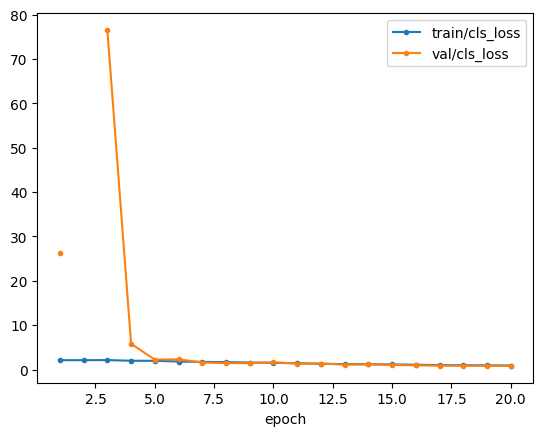

In [33]:
df[["train/cls_loss", "val/cls_loss"]].plot(marker=".")

In [38]:
predict_results = model.predict(
    "/kaggle/input/polyps/Kvasir-SEG/images/cju0roawvklrq0799vmjorwfv.jpg", 
    conf=0.5,
    save=True,
)

f"Results type: {type(predict_results)}, length {len(predict_results)}"


image 1/1 /kaggle/input/polyps/Kvasir-SEG/images/cju0roawvklrq0799vmjorwfv.jpg: 544x640 1 class_0, 45.3ms
Speed: 2.8ms preprocess, 45.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs/detect/train24


"Results type: <class 'list'>, length 1"

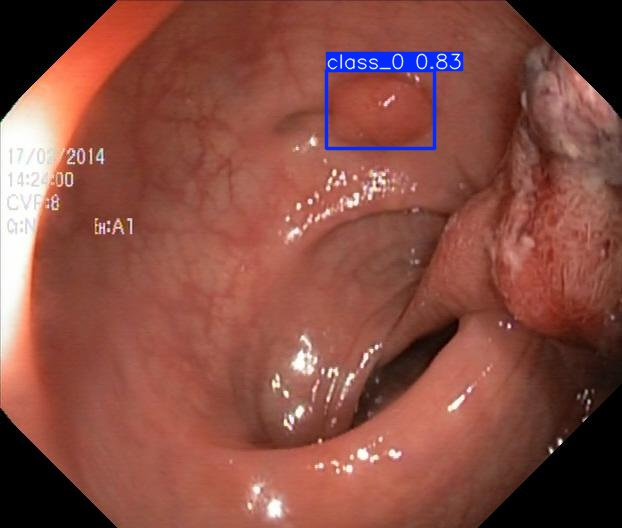

In [40]:
Image.open("/kaggle/working/runs/detect/train24/cju0roawvklrq0799vmjorwfv.jpg")